In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

In [9]:
# Get data

data = pd.read_csv('747.csv')
start_time = 15.9531  # replace with obtained peak value from peaks code
end_time = 23.1638    # replace with obtained peak value from peaks code

filtered_data = data[(data['time (min)'] >= start_time) & (data['time (min)'] <= end_time)]

time = filtered_data['time (min)'].values

detector_voltages = filtered_data.filter(regex='detector voltage').values  # All detector voltage columns
num_detectors = detector_voltages.shape[1]
print(f"Detector voltages shape: {detector_voltages.shape}")
print(f"Number of detectors: {num_detectors}") #verify
print(filtered_data.head())



Detector voltages shape: (845, 17)
Number of detectors: 17
      time (min)  raw light scattering data: detector voltage  (V) detector 2  \
1869   15.953117                                           0.119439             
1870   15.961650                                           0.116753             
1871   15.970183                                           0.116354             
1872   15.978717                                           0.116690             
1873   15.987250                                           0.117378             

      raw light scattering data: detector voltage  (V) detector 3  \
1869                                           0.030916             
1870                                           0.030247             
1871                                           0.030146             
1872                                           0.030176             
1873                                           0.030494             

      raw light scattering data: detect

In [4]:
# Define the time range
start_time = 15.9531  # replace with obtained peak value from peaks code
end_time = 23.1638    # replace with obtained peak value from peaks code

# Create a boolean mask for the time range
time_mask = (data['time (min)'] >= start_time) & (data['time (min)'] <= end_time)

# Apply the mask to filter both time and detector voltages
filtered_time = data['time (min)'][time_mask].values
filtered_detector_voltages = data.filter(regex='detector voltage')[time_mask].values

# Number of detectors (in the filtered range)
num_detectors = filtered_detector_voltages.shape[1]

# Display the shape of the filtered detector voltages array
print(f"Filtered detector voltages shape: {filtered_detector_voltages.shape}")

# Optionally, display the filtered time data to confirm the range
print(f"Filtered time range: {filtered_time.min()} to {filtered_time.max()} minutes")

Filtered detector voltages shape: (845, 17)
Filtered time range: 15.95311651 to 23.15527236 minutes


# USE BETTER DATA HERE, LOOK TO INCLUDE R2 VALUE AND VERIFY ASSUMED VALUES

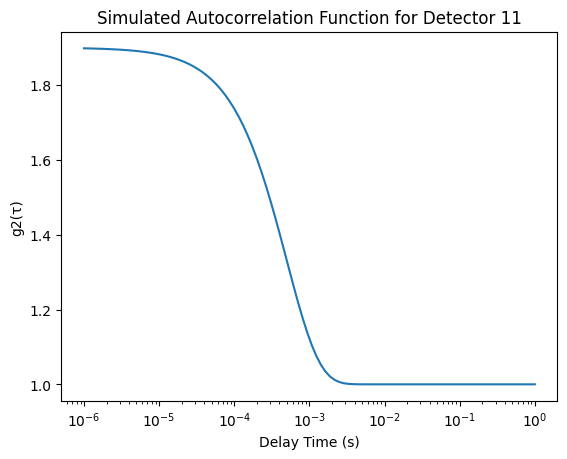

In [11]:
#scattering angles
scattering_angles = np.array([13.07,20.68,29.62,37.48,44.84,53.07,61.08,70.07,80.06,90.00,99.94,109.93,120.06,130.43,140.03,149.02,157.70])
scattering_angles_rad = np.deg2rad(scattering_angles)

#g2(tau)

count_rate = filtered_data['count rate: count rate  (Hz)'].values
#simulate delay times for auto corr function, assuming delay times range from 1e-6 to 1s
tau = np.logspace(-6,0,num=100) #100 points between 1 micro s to 1 s

#simulate g2(tau) using an exp decay model for monodisperse particles, assume gamme value
Gamma_avg = 1e3

#coherence factors beta (instrucment specific, typically between 0.5-1)
beta = 0.9

#simulate g2(tau) for each detector
g2_tau = np.zeros((num_detectors, len(tau)))

for i in range(num_detectors):
    g2_tau[i] = 1 + beta * np.exp(-2 * Gamma_avg * tau)
    
#plot g2(tau) for detector 11 as example
plt.semilogx(tau, g2_tau[9])
plt.xlabel('Delay Time (s)')
plt.ylabel('g2(τ)')
plt.title('Simulated Autocorrelation Function for Detector 11')
plt.show()

# same as above

In [12]:
# Fit g2(tau) to extracy decay rate
def g2_model(tau, beta, Gamma):
    return 1 + beta * np.exp(-2 * Gamma * tau)

# store fitted gamma values
Gamma_values = np.zeros(num_detectors)

#fit g2_tau for each detector
for i in range(num_detectors):
    #initial guesses ?? NEED TO LOOK AT
    initial_guess = [0.9, 1e3]
    
    #curve fit
    popt, pcov = curve_fit(g2_model, tau, g2_tau[i], p0 = initial_guess)
    #extract gamma
    Gamma_values[i] = popt[1]
    
    print(f"Detector {i+2}: Beta = {popt[0]:.3f}, Gamma = {popt[1]:.2e} 1/s")

Detector 2: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 3: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 4: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 5: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 6: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 7: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 8: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 9: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 10: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 11: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 12: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 13: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 14: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 15: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 16: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 17: Beta = 0.900, Gamma = 1.00e+03 1/s
Detector 18: Beta = 0.900, Gamma = 1.00e+03 1/s


# need method for ref. index

In [13]:
# calc scattering vec q
n = 1.33 #ref. index of solvent
lambda_vac = 660e-9
lambda_medium = lambda_vac / n 

q_values = (4* np.pi * n / lambda_vac) * np.sin(scattering_angles_rad / 2)

for i in range(num_detectors):
    print(f"Detector {i+2}: Angle = {scattering_angles[i]:.1f}°, q = {q_values[i]:.2e} m^-1")

Detector 2: Angle = 13.1°, q = 2.88e+06 m^-1
Detector 3: Angle = 20.7°, q = 4.55e+06 m^-1
Detector 4: Angle = 29.6°, q = 6.47e+06 m^-1
Detector 5: Angle = 37.5°, q = 8.14e+06 m^-1
Detector 6: Angle = 44.8°, q = 9.66e+06 m^-1
Detector 7: Angle = 53.1°, q = 1.13e+07 m^-1
Detector 8: Angle = 61.1°, q = 1.29e+07 m^-1
Detector 9: Angle = 70.1°, q = 1.45e+07 m^-1
Detector 10: Angle = 80.1°, q = 1.63e+07 m^-1
Detector 11: Angle = 90.0°, q = 1.79e+07 m^-1
Detector 12: Angle = 99.9°, q = 1.94e+07 m^-1
Detector 13: Angle = 109.9°, q = 2.07e+07 m^-1
Detector 14: Angle = 120.1°, q = 2.19e+07 m^-1
Detector 15: Angle = 130.4°, q = 2.30e+07 m^-1
Detector 16: Angle = 140.0°, q = 2.38e+07 m^-1
Detector 17: Angle = 149.0°, q = 2.44e+07 m^-1
Detector 18: Angle = 157.7°, q = 2.48e+07 m^-1


In [14]:
# Diffusion Coeff
D_values = Gamma_values / q_values ** 2
for i in range(num_detectors):
    print(f"Detector {i+2}: D = {D_values[i]:.2e} m^2/s")


Detector 2: D = 1.20e-10 m^2/s
Detector 3: D = 4.84e-11 m^2/s
Detector 4: D = 2.39e-11 m^2/s
Detector 5: D = 1.51e-11 m^2/s
Detector 6: D = 1.07e-11 m^2/s
Detector 7: D = 7.81e-12 m^2/s
Detector 8: D = 6.04e-12 m^2/s
Detector 9: D = 4.73e-12 m^2/s
Detector 10: D = 3.77e-12 m^2/s
Detector 11: D = 3.12e-12 m^2/s
Detector 12: D = 2.66e-12 m^2/s
Detector 13: D = 2.33e-12 m^2/s
Detector 14: D = 2.08e-12 m^2/s
Detector 15: D = 1.89e-12 m^2/s
Detector 16: D = 1.77e-12 m^2/s
Detector 17: D = 1.68e-12 m^2/s
Detector 18: D = 1.62e-12 m^2/s


In [16]:
#Rh using S-E Eqn.
k_B = 1.380649e-23
T = 296.15 #23 deg
eta = 0.8872e-3 #visc of water

Rh_values = (k_B * T) / (6 * np.pi * eta * D_values)
# convert to nm

Rh_values_nm = Rh_values * 1e9
for i in range(num_detectors):
    print(f"Detector {i+2}: R_h = {Rh_values_nm[i]:.2f} nm")
    
#avg Rh values
Rh_avg = np.mean(Rh_values_nm)
Rh_std = np.std(Rh_values_nm)

print(f"\nAverage Hydrodynamic Radius: {Rh_avg:.2f} ± {Rh_std:.2f} nm")

Detector 2: R_h = 2.03 nm
Detector 3: R_h = 5.05 nm
Detector 4: R_h = 10.24 nm
Detector 5: R_h = 16.18 nm
Detector 6: R_h = 22.81 nm
Detector 7: R_h = 31.29 nm
Detector 8: R_h = 40.48 nm
Detector 9: R_h = 51.67 nm
Detector 10: R_h = 64.86 nm
Detector 11: R_h = 78.39 nm
Detector 12: R_h = 91.92 nm
Detector 13: R_h = 105.12 nm
Detector 14: R_h = 117.66 nm
Detector 15: R_h = 129.23 nm
Detector 16: R_h = 138.47 nm
Detector 17: R_h = 145.60 nm
Detector 18: R_h = 150.92 nm

Average Hydrodynamic Radius: 70.70 ± 51.32 nm


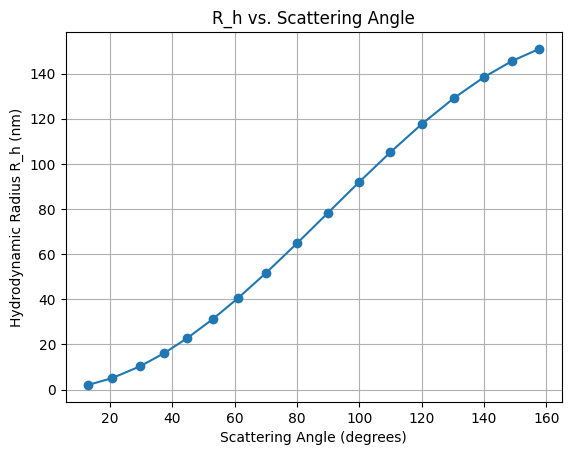

In [17]:
plt.plot(scattering_angles, Rh_values_nm, 'o-')
plt.xlabel('Scattering Angle (degrees)')
plt.ylabel('Hydrodynamic Radius R_h (nm)')
plt.title('R_h vs. Scattering Angle')
plt.grid(True)
plt.show()